C:\Users\m.dhanasekar\AppData\Local\Temp\ipykernel_32756\1305366021.py:70: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(x, t)) if len(t) > 1 else np.nan


,stim_on_abs_s,stim_off_abs_s,baseline_start_s,baseline_end_s,response_start_s,response_end_s,baseline_mean_mV,baseline_sd_mV,peak_dVm_mV,t_peak_s,min_dVm_mV,t_min_s,auc_mV_s,z_peak,z_auc,fr_baseline_Hz,fr_response_Hz,delta_fr_Hz,pct_fr_change,spike_prob
0,100.25,103.25,100.05,100.25,100.25,103.4,-67.591576,1.832773,6.190208,100.33275,-5.864235,102.9288,-11.680536,3.377509,-2.023222,0.0,0.0,0.0,NaN,0.0


Saved metrics to: C:\Users\m.dhanasekar\concatenated_trace_metrics.csv


C:\Users\m.dhanasekar\AppData\Local\Temp\ipykernel_32756\1305366021.py:167: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\m.dhanasekar\AppData\Local\miniforge3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


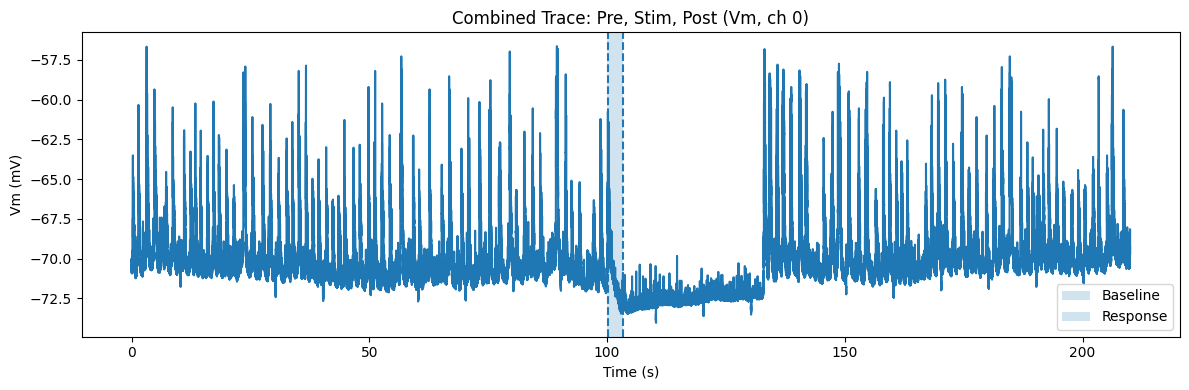

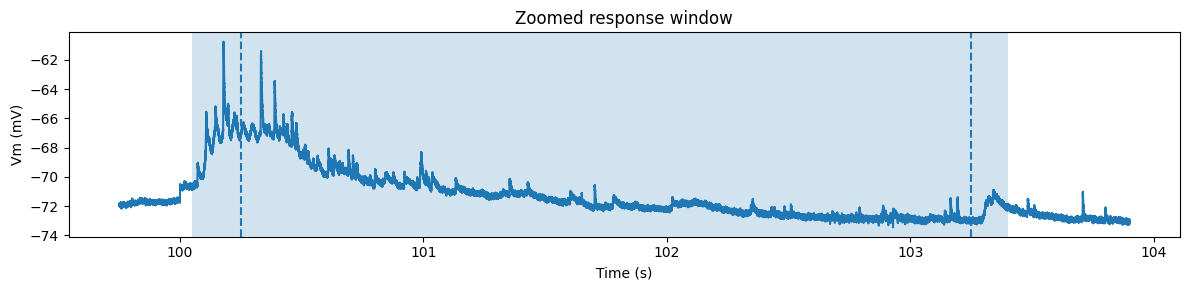

In [1]:
import pyabf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

pre_file_path  = r'C:\Maha\DATA\patch_clamp\Kevin\synaptic_connectivity\opsin\140524_F1_C1\CC\t1\24514026.abf'
stim_file_path = r'C:\Maha\DATA\patch_clamp\Kevin\synaptic_connectivity\opsin\140524_F1_C1\CC\t1\24514027.abf'
post_file_path = r'C:\Maha\DATA\patch_clamp\Kevin\synaptic_connectivity\opsin\140524_F1_C1\CC\t1\24514028.abf'

VM_CHANNEL = 0

# Fixed stimulus times on the concatenated timeline
STIM_START_ABS = 100.25       # seconds
STIM_DURATION_S = 3.0         # seconds
STIM_END_ABS = STIM_START_ABS + STIM_DURATION_S  # 103.25 s

# Analysis windows (relative to ON/OFF)
BASELINE_PRE_S  = 0.200       # baseline duration BEFORE stim ON
RESPONSE_TAIL_S = 0.150       # extend window AFTER stim OFF

# Spike detection (simple threshold)
SPIKE_THRESH_MV = -20.0       # mV
REFRACTORY_S    = 0.002       # seconds

# Output CSV
OUT_METRICS_CSV = "concatenated_trace_metrics.csv"

# ---------------- HELPERS ----------------
def concatenate_sweeps_vm(abf_file_path, vm_channel=0):
    """
    Concatenate all sweeps for VM channel from an ABF into one continuous time/voltage vector.
    Uses per-sweep 'sweepX' and offsets each sweep so time is continuous within that file.
    """
    abf = pyabf.ABF(abf_file_path)
    times = []
    volts = []
    t_offset = 0.0
    for sweepNumber in range(abf.sweepCount):
        abf.setSweep(sweepNumber, channel=vm_channel)
        x = abf.sweepX.copy()
        y = abf.sweepY.copy()
        times.append(x + t_offset)
        volts.append(y)
        t_offset += x[-1]  # start next sweep after this one ends
    return np.concatenate(times), np.concatenate(volts)

def detect_spikes(v, t, thresh_mv=-20.0, refractory_s=0.002):
    """Very simple spike detector: absolute Vm threshold + refractory."""
    idx = np.where(v >= thresh_mv)[0]
    if idx.size == 0:
        return np.array([])
    spk_times = []
    dt = np.median(np.diff(t))
    refr_pts = max(1, int(refractory_s / dt))
    last = -10**9
    for i in idx:
        if i - last >= refr_pts:
            spk_times.append(t[i])
            last = i
    return np.asarray(spk_times)

def window_indices(t, t0, t1):
    return np.where((t >= t0) & (t < t1))[0]

def auc_segment(t, x):
    return float(np.trapz(x, t)) if len(t) > 1 else np.nan

# ---------------- CONCATENATE: pre → stim → post ----------------
pre_time,  pre_trace  = concatenate_sweeps_vm(pre_file_path,  vm_channel=VM_CHANNEL)
stim_time0, stim_tr0  = concatenate_sweeps_vm(stim_file_path, vm_channel=VM_CHANNEL)
post_time0, post_tr0  = concatenate_sweeps_vm(post_file_path, vm_channel=VM_CHANNEL)

# Align stim to follow pre, and post to follow stim
stim_time = stim_time0 + pre_time[-1]
post_time = post_time0 + stim_time[-1]

combined_time  = np.concatenate([pre_time, stim_time, post_time])
combined_trace = np.concatenate([pre_trace, stim_tr0, post_tr0])

# ---------------- ANALYSIS WINDOWS ----------------
baseline_start = STIM_START_ABS - BASELINE_PRE_S
baseline_end   = STIM_START_ABS
resp_start     = STIM_START_ABS
resp_end       = STIM_END_ABS + RESPONSE_TAIL_S

# Guard rails if the concat is shorter than expected
if baseline_start < combined_time[0]: baseline_start = combined_time[0]
if resp_end > combined_time[-1]: resp_end = combined_time[-1]

b_idx = window_indices(combined_time, baseline_start, baseline_end)
r_idx = window_indices(combined_time, resp_start, resp_end)

# ---------------- METRICS ----------------
mu_b  = float(np.mean(combined_trace[b_idx])) if len(b_idx) else np.nan
sd_b  = float(np.std(combined_trace[b_idx], ddof=1)) if len(b_idx) > 1 else 0.0
v_bs  = combined_trace - mu_b  # baseline-subtracted

# Peak/min in response
if len(r_idx):
    seg = v_bs[r_idx]
    tseg = combined_time[r_idx]
    i_max = int(np.argmax(seg)); i_min = int(np.argmin(seg))
    peak     = float(seg[i_max]);  t_peak = float(tseg[i_max])
    min_peak = float(seg[i_min]);  t_min  = float(tseg[i_min])
    auc_val  = auc_segment(tseg, seg)
    dur      = float(tseg[-1] - tseg[0]) if len(tseg) > 1 else np.nan
else:
    peak = min_peak = t_peak = t_min = auc_val = dur = np.nan

z_peak = np.nan if sd_b == 0 else peak / sd_b
z_auc  = np.nan if (sd_b == 0 or not np.isfinite(dur) or dur == 0) else auc_val / (sd_b * dur)

# Spike metrics on raw Vm
spk_times = detect_spikes(combined_trace, combined_time, SPIKE_THRESH_MV, REFRACTORY_S)
b_spk = spk_times[(spk_times >= baseline_start) & (spk_times < baseline_end)]
r_spk = spk_times[(spk_times >= resp_start) & (spk_times < resp_end)]
b_dur = baseline_end - baseline_start
r_dur = resp_end - resp_start
fr_base = len(b_spk) / b_dur if b_dur > 0 else np.nan
fr_resp = len(r_spk) / r_dur if r_dur > 0 else np.nan
delta_fr = fr_resp - fr_base if (np.isfinite(fr_base) and np.isfinite(fr_resp)) else np.nan
pct_fr = np.nan if (not np.isfinite(fr_base) or fr_base == 0) else 100.0 * delta_fr / fr_base

metrics = {
    "stim_on_abs_s": STIM_START_ABS,
    "stim_off_abs_s": STIM_END_ABS,
    "baseline_start_s": baseline_start,
    "baseline_end_s": baseline_end,
    "response_start_s": resp_start,
    "response_end_s": resp_end,
    "baseline_mean_mV": mu_b,
    "baseline_sd_mV": sd_b,
    "peak_dVm_mV": peak,
    "t_peak_s": t_peak,
    "min_dVm_mV": min_peak,
    "t_min_s": t_min,
    "auc_mV_s": auc_val,
    "z_peak": z_peak,
    "z_auc": z_auc,
    "fr_baseline_Hz": fr_base,
    "fr_response_Hz": fr_resp,
    "delta_fr_Hz": delta_fr,
    "pct_fr_change": pct_fr,
    "spike_prob": 1.0 if len(r_spk) > 0 else 0.0,
}

display(pd.DataFrame([metrics]))

pd.DataFrame([metrics]).to_csv(OUT_METRICS_CSV, index=False)
print(f"Saved metrics to: {os.path.abspath(OUT_METRICS_CSV)}")

# ---------------- PLOTS ----------------
plt.figure(figsize=(12, 4))
plt.plot(combined_time, combined_trace)
plt.axvspan(baseline_start, baseline_end, alpha=0.2, label="Baseline")
plt.axvspan(resp_start, resp_end, alpha=0.2, label="Response")
plt.axvline(STIM_START_ABS, linestyle='--')
plt.axvline(STIM_END_ABS, linestyle='--')
plt.title('Combined Trace: Pre, Stim, Post (Vm, ch 0)')
plt.xlabel('Time (s)')
plt.ylabel('Vm (mV)')
plt.legend()
plt.tight_layout()
plt.show()

# Zoom around the response
zoom_pad = 0.5  # seconds
z0 = max(combined_time[0], STIM_START_ABS - zoom_pad)
z1 = min(combined_time[-1], STIM_END_ABS + RESPONSE_TAIL_S + zoom_pad)

plt.figure(figsize=(12, 3))
sel = (combined_time >= z0) & (combined_time <= z1)
plt.plot(combined_time[sel], combined_trace[sel])
plt.axvspan(baseline_start, baseline_end, alpha=0.2)
plt.axvspan(resp_start, resp_end, alpha=0.2)
plt.axvline(STIM_START_ABS, linestyle='--')
plt.axvline(STIM_END_ABS, linestyle='--')
plt.title('Zoomed response window')
plt.xlabel('Time (s)')
plt.ylabel('Vm (mV)')
plt.tight_layout()
plt.show()


C:\Users\m.dhanasekar\AppData\Local\Temp\ipykernel_32756\2902421805.py:92: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(x, t)) if len(t) > 1 else np.nan


,fs_Hz,lp_cutoff_Hz,lp_order,stim_on_abs_s,stim_off_abs_s,baseline_start_s,baseline_end_s,response_start_s,response_end_s,baseline_mean_mV,...,min_dVm_mV,t_min_s,auc_mV_s,z_peak,z_auc,fr_baseline_Hz,fr_response_Hz,delta_fr_Hz,pct_fr_change,spike_prob
0,99999.999968,20.0,4,100.25,103.25,100.05,100.25,100.25,103.4,-62.220814,...,0.3922,100.28421,24.595463,206.24871,20.793174,0.0,4.126984,4.126984,NaN,1.0


Saved metrics to: C:\Users\m.dhanasekar\concatenated_trace_metrics.csv


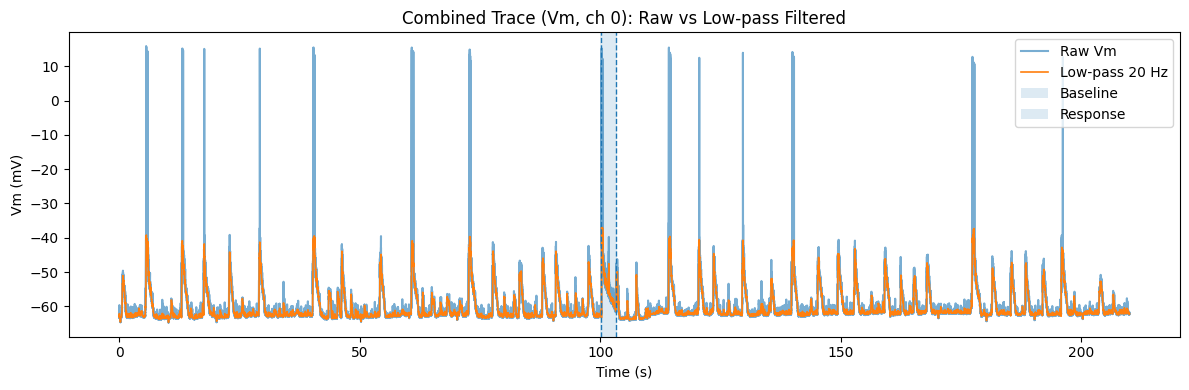

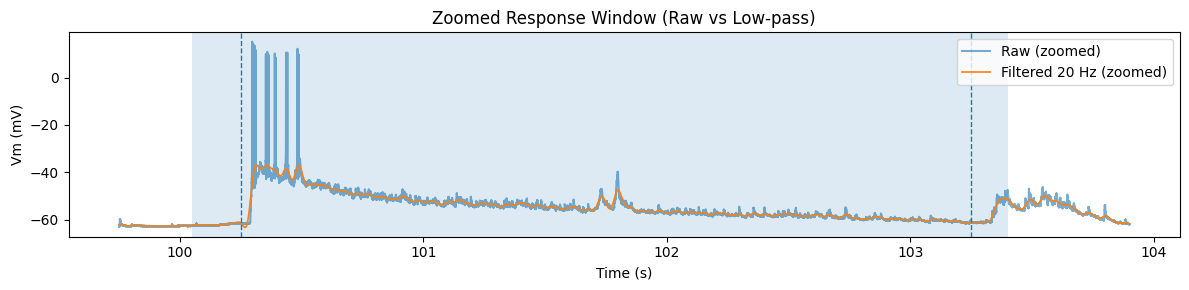

In [4]:
# JUPYTER CELL — Concatenate pre/stim/post ABFs (Vm ch 0), fixed stim window (100.25–103.25 s), analyze current clamp
import pyabf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.signal import butter, filtfilt

# ---------------- CONFIG (EDIT PATHS IF NEEDED) ----------------
pre_file_path  = r'C:\Maha\DATA\patch_clamp\Kevin\synaptic_connectivity\control\100624_F1_C1\CC\t1\24610007.abf'
stim_file_path = r'C:\Maha\DATA\patch_clamp\Kevin\synaptic_connectivity\control\100624_F1_C1\CC\t1\24610008.abf'
post_file_path = r'C:\Maha\DATA\patch_clamp\Kevin\synaptic_connectivity\control\100624_F1_C1\CC\t1\24610009.abf'

VM_CHANNEL = 0

# Fixed stimulus times on the concatenated timeline
STIM_START_ABS = 100.25       # seconds
STIM_DURATION_S = 3.0         # seconds
STIM_END_ABS = STIM_START_ABS + STIM_DURATION_S  # 103.25 s

# Analysis windows (relative to ON/OFF)
BASELINE_PRE_S  = 0.200       # baseline duration BEFORE stim ON
RESPONSE_TAIL_S = 0.150       # extend window AFTER stim OFF

# Spike detection (simple threshold)
SPIKE_THRESH_MV = -20.0       # mV
REFRACTORY_S    = 0.002       # seconds

# Output CSV
OUT_METRICS_CSV = "concatenated_trace_metrics.csv"

# ---------------- LOW-PASS FILTER CONFIG ----------------
CUTOFF_HZ = 20.0   # keep Vm components below ~20 Hz (adjust as needed)
ORDER     = 4

def butter_lowpass(cutoff_hz, fs_hz, order=4):
    nyq = 0.5 * fs_hz
    b, a = butter(order, cutoff_hz / nyq, btype='low')
    return b, a

def apply_lowpass_zero_phase(x, fs_hz, cutoff_hz, order=4):
    """Zero-phase low-pass with sane handling for short vectors."""
    b, a = butter_lowpass(cutoff_hz, fs_hz, order)
    # filtfilt padlen guard for short signals
    padlen = 3 * max(len(a), len(b))
    if x.size <= padlen:
        # fall back to lfilter twice (introduces some phase lag removal, but not as ideal)
        from scipy.signal import lfilter
        y = lfilter(b, a, x)
        y = lfilter(b, a, y[::-1])[::-1]
        return y
    return filtfilt(b, a, x)

# ---------------- HELPERS ----------------
def concatenate_sweeps_vm(abf_file_path, vm_channel=0):
    """
    Concatenate all sweeps for VM channel from an ABF into one continuous time/voltage vector.
    Uses per-sweep 'sweepX' and offsets each sweep so time is continuous within that file.
    """
    abf = pyabf.ABF(abf_file_path)
    times = []
    volts = []
    t_offset = 0.0
    for sweepNumber in range(abf.sweepCount):
        abf.setSweep(sweepNumber, channel=vm_channel)
        x = abf.sweepX.copy()
        y = abf.sweepY.copy()
        times.append(x + t_offset)
        volts.append(y)
        t_offset += x[-1]  # start next sweep after this one ends
    return np.concatenate(times), np.concatenate(volts)

def detect_spikes(v, t, thresh_mv=-20.0, refractory_s=0.002):
    """Very simple spike detector: absolute Vm threshold + refractory."""
    idx = np.where(v >= thresh_mv)[0]
    if idx.size == 0:
        return np.array([])
    spk_times = []
    dt = np.median(np.diff(t))
    refr_pts = max(1, int(refractory_s / dt))
    last = -10**9
    for i in idx:
        if i - last >= refr_pts:
            spk_times.append(t[i])
            last = i
    return np.asarray(spk_times)

def window_indices(t, t0, t1):
    return np.where((t >= t0) & (t < t1))[0]

def auc_segment(t, x):
    return float(np.trapz(x, t)) if len(t) > 1 else np.nan

# ---------------- CONCATENATE: pre → stim → post ----------------
pre_time,  pre_trace  = concatenate_sweeps_vm(pre_file_path,  vm_channel=VM_CHANNEL)
stim_time0, stim_tr0  = concatenate_sweeps_vm(stim_file_path, vm_channel=VM_CHANNEL)
post_time0, post_tr0  = concatenate_sweeps_vm(post_file_path, vm_channel=VM_CHANNEL)

# Align stim to follow pre, and post to follow stim
stim_time = stim_time0 + pre_time[-1]
post_time = post_time0 + stim_time[-1]

combined_time  = np.concatenate([pre_time, stim_time, post_time])
combined_trace = np.concatenate([pre_trace, stim_tr0, post_tr0])

# ---------------- DERIVE SAMPLING RATE & FILTER ----------------
dt = float(np.median(np.diff(combined_time)))
if dt <= 0:
    raise ValueError("Combined time vector is not strictly increasing.")
fs_hz = 1.0 / dt

filtered_trace = apply_lowpass_zero_phase(combined_trace, fs_hz=fs_hz,
                                          cutoff_hz=CUTOFF_HZ, order=ORDER)

# ---------------- ANALYSIS WINDOWS ----------------
baseline_start = STIM_START_ABS - BASELINE_PRE_S
baseline_end   = STIM_START_ABS
resp_start     = STIM_START_ABS
resp_end       = STIM_END_ABS + RESPONSE_TAIL_S

# Guard rails if the concat is shorter than expected
if baseline_start < combined_time[0]: baseline_start = combined_time[0]
if resp_end > combined_time[-1]: resp_end = combined_time[-1]

b_idx = window_indices(combined_time, baseline_start, baseline_end)
r_idx = window_indices(combined_time, resp_start, resp_end)

# ---------------- METRICS ----------------
mu_b  = float(np.mean(combined_trace[b_idx])) if len(b_idx) else np.nan
sd_b  = float(np.std(combined_trace[b_idx], ddof=1)) if len(b_idx) > 1 else 0.0
v_bs  = combined_trace - mu_b  # baseline-subtracted

# Peak/min in response
if len(r_idx):
    seg = v_bs[r_idx]
    tseg = combined_time[r_idx]
    i_max = int(np.argmax(seg)); i_min = int(np.argmin(seg))
    peak     = float(seg[i_max]);  t_peak = float(tseg[i_max])
    min_peak = float(seg[i_min]);  t_min  = float(tseg[i_min])
    auc_val  = auc_segment(tseg, seg)
    dur      = float(tseg[-1] - tseg[0]) if len(tseg) > 1 else np.nan
else:
    peak = min_peak = t_peak = t_min = auc_val = dur = np.nan

z_peak = np.nan if sd_b == 0 else peak / sd_b
z_auc  = np.nan if (sd_b == 0 or not np.isfinite(dur) or dur == 0) else auc_val / (sd_b * dur)

# Spike metrics on raw Vm
spk_times = detect_spikes(combined_trace, combined_time, SPIKE_THRESH_MV, REFRACTORY_S)
b_spk = spk_times[(spk_times >= baseline_start) & (spk_times < baseline_end)]
r_spk = spk_times[(spk_times >= resp_start) & (spk_times < resp_end)]
b_dur = baseline_end - baseline_start
r_dur = resp_end - resp_start
fr_base = len(b_spk) / b_dur if b_dur > 0 else np.nan
fr_resp = len(r_spk) / r_dur if r_dur > 0 else np.nan
delta_fr = fr_resp - fr_base if (np.isfinite(fr_base) and np.isfinite(fr_resp)) else np.nan
pct_fr = np.nan if (not np.isfinite(fr_base) or fr_base == 0) else 100.0 * delta_fr / fr_base

metrics = {
    "fs_Hz": fs_hz,
    "lp_cutoff_Hz": CUTOFF_HZ,
    "lp_order": ORDER,
    "stim_on_abs_s": STIM_START_ABS,
    "stim_off_abs_s": STIM_END_ABS,
    "baseline_start_s": baseline_start,
    "baseline_end_s": baseline_end,
    "response_start_s": resp_start,
    "response_end_s": resp_end,
    "baseline_mean_mV": mu_b,
    "baseline_sd_mV": sd_b,
    "peak_dVm_mV": peak,
    "t_peak_s": t_peak,
    "min_dVm_mV": min_peak,
    "t_min_s": t_min,
    "auc_mV_s": auc_val,
    "z_peak": z_peak,
    "z_auc": z_auc,
    "fr_baseline_Hz": fr_base,
    "fr_response_Hz": fr_resp,
    "delta_fr_Hz": delta_fr,
    "pct_fr_change": pct_fr,
    "spike_prob": 1.0 if len(r_spk) > 0 else 0.0,
}

display(pd.DataFrame([metrics]))
pd.DataFrame([metrics]).to_csv(OUT_METRICS_CSV, index=False)
print(f"Saved metrics to: {os.path.abspath(OUT_METRICS_CSV)}")

# ---------------- PLOTS (RAW vs FILTERED) ----------------
plt.figure(figsize=(12, 4))
plt.plot(combined_time, combined_trace, label="Raw Vm", alpha=0.6)
plt.plot(combined_time, filtered_trace, label=f"Low-pass {CUTOFF_HZ:.0f} Hz", linewidth=1.2)
plt.axvspan(baseline_start, baseline_end, alpha=0.15, label="Baseline")
plt.axvspan(resp_start, resp_end, alpha=0.15, label="Response")
plt.axvline(STIM_START_ABS, linestyle='--', linewidth=1)
plt.axvline(STIM_END_ABS, linestyle='--', linewidth=1)
plt.title('Combined Trace (Vm, ch 0): Raw vs Low-pass Filtered')
plt.xlabel('Time (s)')
plt.ylabel('Vm (mV)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Zoom around the response
zoom_pad = 0.5  # seconds
z0 = max(combined_time[0], STIM_START_ABS - zoom_pad)
z1 = min(combined_time[-1], STIM_END_ABS + RESPONSE_TAIL_S + zoom_pad)
sel = (combined_time >= z0) & (combined_time <= z1)

plt.figure(figsize=(12, 3))
plt.plot(combined_time[sel], combined_trace[sel], label="Raw (zoomed)", alpha=0.6)
plt.plot(combined_time[sel], filtered_trace[sel], label=f"Filtered {CUTOFF_HZ:.0f} Hz (zoomed)", linewidth=1.2)
plt.axvspan(baseline_start, baseline_end, alpha=0.15)
plt.axvspan(resp_start, resp_end, alpha=0.15)
plt.axvline(STIM_START_ABS, linestyle='--', linewidth=1)
plt.axvline(STIM_END_ABS, linestyle='--', linewidth=1)
plt.title('Zoomed Response Window (Raw vs Low-pass)')
plt.xlabel('Time (s)')
plt.ylabel('Vm (mV)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


C:\Users\m.dhanasekar\AppData\Local\Temp\ipykernel_32756\3744413231.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data, labels=labels, showfliers=True)


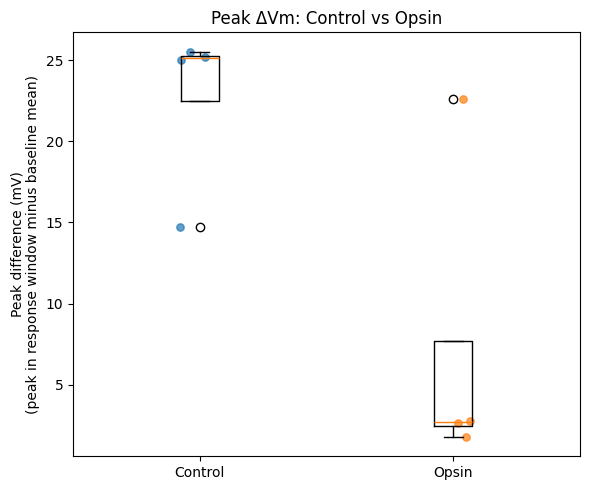

Saved box plot: C:\Maha\DATA\patch_clamp\Kevin\synaptic_connectivity\PeakDifference_Boxplot.pdf
Saved box plot (SVG): C:\Maha\DATA\patch_clamp\Kevin\synaptic_connectivity\PeakDifference_Boxplot.svg
Saved stats: C:\Maha\DATA\patch_clamp\Kevin\synaptic_connectivity\PeakDifference_stats.txt


In [10]:
# === Box plot of peak difference (peak - baseline) and statistical test ===
# Uses `summary_rows` and `root_dir` from the previous cell.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro, ttest_ind, mannwhitneyu

# Build DataFrame of steps (peak - baseline) for each pair
df_steps = pd.DataFrame(summary_rows)

ctrl = df_steps["step_control_mV"].astype(float).dropna().to_numpy()
ops  = df_steps["step_opsin_mV"].astype(float).dropna().to_numpy()

# Boxplot (with scatter overlays) — save as both PDF and SVG
plt.figure(figsize=(6, 5))
data = [ctrl, ops]
labels = ["Control", "Opsin"]
bp = plt.boxplot(data, labels=labels, showfliers=True)

# jittered scatter points for visibility
rng = np.random.default_rng(0)
for i, vals in enumerate(data, start=1):
    if len(vals):
        x = np.full_like(vals, i, dtype=float) + (rng.uniform(-0.08, 0.08, size=len(vals)))
        plt.scatter(x, vals, s=28, alpha=0.7)

plt.ylabel("Peak difference (mV)\n(peak in response window minus baseline mean)")
plt.title("Peak ΔVm: Control vs Opsin")
plt.tight_layout()

box_pdf = os.path.join(root_dir, "PeakDifference_Boxplot.pdf")
box_svg = os.path.join(root_dir, "PeakDifference_Boxplot.svg")
plt.savefig(box_pdf, format="pdf")
plt.savefig(box_svg, format="svg", dpi=300)
plt.show()

# ---------- Stats ----------
# Normality (Shapiro–Wilk) if n>=3; fall back if it errors or n<3
def safe_shapiro(x):
    try:
        if len(x) >= 3:
            return shapiro(x)
    except Exception:
        pass
    return (np.nan, np.nan)

W_ctrl, p_ctrl_norm = safe_shapiro(ctrl)
W_ops,  p_ops_norm  = safe_shapiro(ops)

normal = (np.isfinite(p_ctrl_norm) and np.isfinite(p_ops_norm) and
          p_ctrl_norm > 0.05 and p_ops_norm > 0.05 and len(ctrl) >= 2 and len(ops) >= 2)

if normal:
    test_name = "Welch's t-test"
    stat, pval = ttest_ind(ctrl, ops, equal_var=False, nan_policy="omit")
    # Cohen's d (Hedges' g small-sample corrected)
    def hedges_g(a, b):
        na, nb = len(a), len(b)
        sa, sb = np.var(a, ddof=1), np.var(b, ddof=1)
        sp = np.sqrt(((na-1)*sa + (nb-1)*sb) / (na + nb - 2))
        if sp == 0:
            return np.nan
        d = (np.mean(b) - np.mean(a)) / sp
        # small sample correction
        J = 1 - (3 / (4*(na + nb) - 9))
        return J * d
    effect = hedges_g(ctrl, ops)
    effect_name = "Hedges' g (Opsin−Control)"
else:
    test_name = "Mann–Whitney U"
    stat, pval = mannwhitneyu(ctrl, ops, alternative="two-sided")
    # Rank-biserial correlation
    n1, n2 = len(ctrl), len(ops)
    if n1 > 0 and n2 > 0:
        # Convert U to rank-biserial r_rb = 1 - 2U/(n1*n2)
        # (sign depends on which group tends to be larger; this is symmetric two-sided)
        r_rb = 1 - (2 * stat) / (n1 * n2)
    else:
        r_rb = np.nan
    effect = r_rb
    effect_name = "Rank-biserial r (Opsin vs Control)"

# Save a stats report
stats_txt = os.path.join(root_dir, "PeakDifference_stats.txt")
with open(stats_txt, "w", encoding="utf-8") as f:
    f.write("Peak difference (mV) = max(Vm in response window) − mean(Vm in baseline window)\n")
    f.write(f"Baseline window: [{STIM_START_ABS - BASELINE_PRE_S:.3f}, {STIM_START_ABS:.3f}] s\n")
    f.write(f"Response window: [{STIM_START_ABS:.3f}, {STIM_END_ABS + RESPONSE_TAIL_S:.3f}] s\n\n")
    f.write(f"N_control = {len(ctrl)}, mean = {np.nanmean(ctrl):.3f}, SD = {np.nanstd(ctrl, ddof=1):.3f}\n")
    f.write(f"N_opsin   = {len(ops)},  mean = {np.nanmean(ops):.3f}, SD = {np.nanstd(ops, ddof=1):.3f}\n\n")
    f.write(f"Normality p-values (Shapiro): Control={p_ctrl_norm}, Opsin={p_ops_norm}\n")
    f.write(f"Test used: {test_name}\n")
    f.write(f"Statistic = {stat:.4g}, p = {pval:.4g}\n")
    f.write(f"Effect size: {effect_name} = {effect:.4g}\n")

print(f"Saved box plot: {box_pdf}")
print(f"Saved box plot (SVG): {box_svg}")
print(f"Saved stats: {stats_txt}")


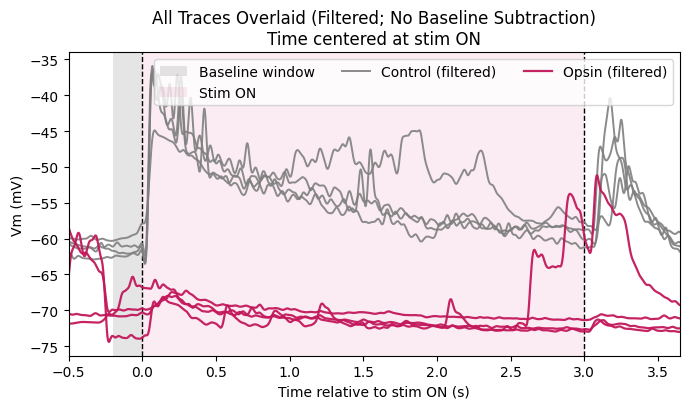

In [1]:
# JUPYTER CELL — Concatenate ABFs, Low-Pass Filter, Save PDFs/SVGs, and Run Peak-Difference Stats
# - Each folder holds exactly THREE .abf files (pre, stim, post), concatenated in ascending numeric order
# - Plots are on the filtered (Butterworth) traces WITHOUT baseline subtraction
# - Baseline = mean Vm in pre-onset window; Peak difference = max(Vm response window) − baseline
# - Saves: individual per-trace PDFs, an all-traces overlay SVG, a boxplot PDF+SVG, and a stats TXT + CSV
# -----------------------------------------------------------------------------------------------

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyabf
from scipy.signal import butter, filtfilt, lfilter
from scipy.stats import shapiro, ttest_ind, mannwhitneyu

# ---------------- USER INPUT ----------------
CONTROL_FOLDERS = [
    r"C:\Maha\DATA\patch_clamp\Kevin\synaptic_connectivity\control\100624_F1_C1\CC\t1",
    r"C:\Maha\DATA\patch_clamp\Kevin\synaptic_connectivity\control\100624_F1_C1\CC\t2",
    r"C:\Maha\DATA\patch_clamp\Kevin\synaptic_connectivity\control\100624_F1_C1\CC\t3",
    r"C:\Maha\DATA\patch_clamp\Kevin\synaptic_connectivity\control\100624_F2_C1\CC\t1"
]
OPSIN_FOLDERS = [
   r"C:\Maha\DATA\patch_clamp\Kevin\synaptic_connectivity\opsin\140524_F1_C1\CC\t1",
   r"C:\Maha\DATA\patch_clamp\Kevin\synaptic_connectivity\opsin\140524_F1_C1\CC\t3",
   r"C:\Maha\DATA\patch_clamp\Kevin\synaptic_connectivity\opsin\140524_F1_C1\CC\t4",
   r"C:\Maha\DATA\patch_clamp\Kevin\synaptic_connectivity\opsin\150424_F1_C1\CC\t1",
]

VM_CHANNEL = 0

# Stimulus timing on the concatenated timeline
STIM_START_ABS  = 100.25     # s
STIM_DURATION_S = 3.0        # s
STIM_END_ABS    = STIM_START_ABS + STIM_DURATION_S

# Baseline / response windows
BASELINE_PRE_S   = 0.200     # seconds BEFORE stim ON used for baseline (mean)
RESPONSE_TAIL_S  = 0.150     # seconds AFTER stim OFF included in response

# Zoom around stim for plotting (relative to stim ON)
ZOOM_PAD_PRE     = 0.50
ZOOM_PAD_POST    = 0.50

# Low-pass filter
LP_CUTOFF_HZ = 20.0          # adjust as needed
LP_ORDER     = 4

# Plotting colors/styles
COLOR_CONTROL = "#7f7f7f"    # grey
COLOR_OPSIN   = "#C2185B"    # dark pink
LW_CTRL       = 1.4
LW_OPS        = 1.6
ALPHA_CTRL    = 0.9
ALPHA_OPS     = 0.95

# ---------------- HELPERS ----------------
def numeric_key(path):
    fname = os.path.basename(path)
    nums = re.findall(r"\d+", fname)
    return tuple(int(n) for n in nums) if nums else (fname.lower(),)

def list_three_abfs_sorted(folder):
    abfs = [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(".abf")]
    if len(abfs) != 3:
        raise ValueError(f"Folder must contain exactly 3 ABFs: {folder} (found {len(abfs)})")
    abfs.sort(key=numeric_key)
    return abfs

def concat_one_abf(abf_path, vm_channel=0):
    abf = pyabf.ABF(abf_path)
    times, volts = [], []
    t_offset = 0.0
    for s in range(abf.sweepCount):
        abf.setSweep(s, channel=vm_channel)
        x = abf.sweepX.copy()
        y = abf.sweepY.copy()
        times.append(x + t_offset)
        volts.append(y)
        t_offset += x[-1]
    return np.concatenate(times), np.concatenate(volts)

def concat_three_abfs_sequential(folder, vm_channel=0):
    abf_paths = list_three_abfs_sorted(folder)
    t_all, v_all, t_offset = [], [], 0.0
    for p in abf_paths:
        t, v = concat_one_abf(p, vm_channel)
        t_all.append(t + t_offset)
        v_all.append(v)
        t_offset += t[-1]
    return np.concatenate(t_all), np.concatenate(v_all), abf_paths

def compute_fs(t):
    dt = float(np.median(np.diff(t)))
    if dt <= 0:
        raise ValueError("Non-increasing time vector.")
    return 1.0 / dt

def butter_lowpass(cutoff_hz, fs_hz, order=4):
    nyq = 0.5 * fs_hz
    return butter(order, cutoff_hz / nyq, btype='low', analog=False)

def apply_lowpass_zero_phase(x, fs_hz, cutoff_hz, order=4):
    b, a = butter_lowpass(cutoff_hz, fs_hz, order)
    padlen = 3 * max(len(a), len(b))
    if x.size <= padlen:
        y = lfilter(b, a, x)
        y = lfilter(b, a, y[::-1])[::-1]
        return y
    return filtfilt(b, a, x)

def window_mask(t, t0, t1):
    return (t >= t0) & (t <= t1)

def safe_mean(x):
    return float(np.mean(x)) if x.size > 0 else np.nan

def safe_max(x):
    return float(np.max(x)) if x.size > 0 else np.nan

# ---------------- ROOT OUTPUT DIR ----------------
root_dir = os.path.commonpath(CONTROL_FOLDERS + OPSIN_FOLDERS)
os.makedirs(root_dir, exist_ok=True)

# ---------------- PROCESS & SAVE ----------------
if len(CONTROL_FOLDERS) != len(OPSIN_FOLDERS):
    raise ValueError("CONTROL_FOLDERS and OPSIN_FOLDERS must have the same length.")

# For overlay of ALL traces (filtered, no baseline subtraction)
all_ctrl_rel, all_ctrl_val = [], []
all_ops_rel,  all_ops_val  = [], []

# For summary and stats
summary_rows = []

# Common relative zoom window
z0_rel = -ZOOM_PAD_PRE
z1_rel = STIM_DURATION_S + RESPONSE_TAIL_S + ZOOM_PAD_POST

for pair_idx, (ctrl_folder, ops_folder) in enumerate(zip(CONTROL_FOLDERS, OPSIN_FOLDERS), start=1):
    # --- CONTROL ---
    t_ctrl, v_ctrl, ctrl_files = concat_three_abfs_sequential(ctrl_folder, VM_CHANNEL)
    fs_ctrl = compute_fs(t_ctrl)
    v_ctrl_f = apply_lowpass_zero_phase(v_ctrl, fs_ctrl, LP_CUTOFF_HZ, LP_ORDER)

    base0_abs = STIM_START_ABS - BASELINE_PRE_S
    base1_abs = STIM_START_ABS
    resp0_abs = STIM_START_ABS
    resp1_abs = STIM_END_ABS + RESPONSE_TAIL_S

    m_base_c = window_mask(t_ctrl, base0_abs, base1_abs)
    m_resp_c = window_mask(t_ctrl, resp0_abs, resp1_abs)

    base_ctrl = safe_mean(v_ctrl_f[m_base_c])
    peak_ctrl = safe_max(v_ctrl_f[m_resp_c])
    step_ctrl = (peak_ctrl - base_ctrl) if (np.isfinite(peak_ctrl) and np.isfinite(base_ctrl)) else np.nan

    t_ctrl_rel = t_ctrl - STIM_START_ABS
    m_plot_c = window_mask(t_ctrl_rel, z0_rel, z1_rel)

    # Save individual CONTROL trace PDF
    plt.figure(figsize=(12, 3.8))
    plt.plot(t_ctrl_rel[m_plot_c], v_ctrl_f[m_plot_c], color=COLOR_CONTROL, lw=LW_CTRL, alpha=ALPHA_CTRL, label="Control (filtered)")
    plt.axvspan(-BASELINE_PRE_S, 0.0, alpha=0.10, color="k", linewidth=0)
    plt.axvspan(0.0, STIM_DURATION_S, alpha=0.10, color=COLOR_OPSIN, linewidth=0)
    plt.axvline(0.0, linestyle="--", color="k", lw=1)
    plt.axvline(STIM_DURATION_S, linestyle="--", color="k", lw=1)
    ctrl_tag = " + ".join(os.path.basename(p) for p in ctrl_files)
    plt.title(f"Pair {pair_idx} — CONTROL (filtered; no baseline subtraction)\n{ctrl_tag}")
    plt.xlabel("Time relative to stim ON (s)")
    plt.ylabel("Vm (mV)")
    plt.xlim(z0_rel, z1_rel)
    plt.legend(loc="upper right")
    plt.tight_layout()
    ctrl_pdf = os.path.join(root_dir, f"Pair{pair_idx:02d}_CONTROL_filtered.pdf")
    plt.savefig(ctrl_pdf, format="pdf")
    plt.close()

    all_ctrl_rel.append(t_ctrl_rel[m_plot_c])
    all_ctrl_val.append(v_ctrl_f[m_plot_c])

    # --- OPSIN ---
    t_ops, v_ops, ops_files = concat_three_abfs_sequential(ops_folder, VM_CHANNEL)
    fs_ops = compute_fs(t_ops)
    v_ops_f = apply_lowpass_zero_phase(v_ops, fs_ops, LP_CUTOFF_HZ, LP_ORDER)

    m_base_o = window_mask(t_ops, base0_abs, base1_abs)
    m_resp_o = window_mask(t_ops, resp0_abs, resp1_abs)

    base_ops = safe_mean(v_ops_f[m_base_o])
    peak_ops = safe_max(v_ops_f[m_resp_o])
    step_ops = (peak_ops - base_ops) if (np.isfinite(peak_ops) and np.isfinite(base_ops)) else np.nan

    t_ops_rel = t_ops - STIM_START_ABS
    m_plot_o = window_mask(t_ops_rel, z0_rel, z1_rel)

    # Save individual OPSIN trace PDF
    plt.figure(figsize=(12, 3.8))
    plt.plot(t_ops_rel[m_plot_o], v_ops_f[m_plot_o], color=COLOR_OPSIN, lw=LW_OPS, alpha=ALPHA_OPS, label="Opsin (filtered)")
    plt.axvspan(-BASELINE_PRE_S, 0.0, alpha=0.10, color="k", linewidth=0)
    plt.axvspan(0.0, STIM_DURATION_S, alpha=0.10, color=COLOR_OPSIN, linewidth=0)
    plt.axvline(0.0, linestyle="--", color="k", lw=1)
    plt.axvline(STIM_DURATION_S, linestyle="--", color="k", lw=1)
    ops_tag  = " + ".join(os.path.basename(p) for p in ops_files)
    plt.title(f"Pair {pair_idx} — OPSIN (filtered; no baseline subtraction)\n{ops_tag}")
    plt.xlabel("Time relative to stim ON (s)")
    plt.ylabel("Vm (mV)")
    plt.xlim(z0_rel, z1_rel)
    plt.legend(loc="upper right")
    plt.tight_layout()
    ops_pdf = os.path.join(root_dir, f"Pair{pair_idx:02d}_OPSIN_filtered.pdf")
    plt.savefig(ops_pdf, format="pdf")
    plt.close()

    all_ops_rel.append(t_ops_rel[m_plot_o])
    all_ops_val.append(v_ops_f[m_plot_o])

    summary_rows.append({
        "pair": pair_idx,
        "control_folder": ctrl_folder,
        "opsin_folder": ops_folder,
        "fs_control_Hz": fs_ctrl,
        "fs_opsin_Hz": fs_ops,
        "baseline_control_mV": base_ctrl,
        "peak_control_mV": peak_ctrl,
        "step_control_mV": step_ctrl,
        "baseline_opsin_mV": base_ops,
        "peak_opsin_mV": peak_ops,
        "step_opsin_mV": step_ops,
        "control_pdf": ctrl_pdf,
        "opsin_pdf": ops_pdf
    })

# ---------------- OVERLAY ALL TRACES (ONE AXIS) & SAVE SVG ----------------
plt.figure(figsize=(7, 4.2))
plt.axvspan(-BASELINE_PRE_S, 0.0, alpha=0.10, color="k", linewidth=0, label="Baseline window")
plt.axvspan(0.0, STIM_DURATION_S, alpha=0.08, color=COLOR_OPSIN, linewidth=0, label="Stim ON")
plt.axvline(0.0, linestyle="--", color="k", lw=1)
plt.axvline(STIM_DURATION_S, linestyle="--", color="k", lw=1)
plt.plot([], [], color=COLOR_CONTROL, lw=LW_CTRL, alpha=ALPHA_CTRL, label="Control (filtered)")
plt.plot([], [], color=COLOR_OPSIN,   lw=LW_OPS,  alpha=ALPHA_OPS,  label="Opsin (filtered)")
for t_rel, v in zip(all_ctrl_rel, all_ctrl_val):
    plt.plot(t_rel, v, color=COLOR_CONTROL, lw=LW_CTRL, alpha=ALPHA_CTRL)
for t_rel, v in zip(all_ops_rel, all_ops_val):
    plt.plot(t_rel, v, color=COLOR_OPSIN, lw=LW_OPS, alpha=ALPHA_OPS)
plt.title("All Traces Overlaid (Filtered; No Baseline Subtraction)\nTime centered at stim ON")
plt.xlabel("Time relative to stim ON (s)")
plt.ylabel("Vm (mV)")
plt.xlim(z0_rel, z1_rel)
plt.legend(loc="upper right", ncol=3)
plt.tight_layout()
overlay_svg = os.path.join(root_dir, "AllTraces_Overlay_filtered.svg")
plt.savefig(overlay_svg, format="svg", dpi=300)
plt.show()



In [2]:
# ==========================
# Peak Deflection Stats Snippet
# ==========================

import numpy as np
import pandas as pd
from scipy.stats import shapiro, ttest_ind, mannwhitneyu

# ----------------------------------------
# Example input arrays (replace with your data)
# ----------------------------------------
ctrl = np.array([-2.3, -2.8, -3.0, -2.5, -2.1])   # Control ΔVm values (mV)
ops  = np.array([-1.2, -1.5, -1.8, -1.0, -1.3])   # Opsin ΔVm values (mV)

# ----------------------------------------
# Helper: standard error of mean
# ----------------------------------------
def sem(x):
    x = np.asarray(x, dtype=float)
    return np.std(x, ddof=1) / np.sqrt(len(x)) if len(x) else np.nan

# ----------------------------------------
# Descriptive statistics
# ----------------------------------------
def describe(x, label):
    return {
        "Group": label,
        "N": len(x),
        "Mean": np.mean(x),
        "SD": np.std(x, ddof=1),
        "SEM": sem(x),
        "Median": np.median(x),
        "Q1": np.percentile(x, 25),
        "Q3": np.percentile(x, 75)
    }

df_stats = pd.DataFrame([describe(ctrl, "Control"), describe(ops, "Opsin")])

# ----------------------------------------
# Test for normality (Shapiro–Wilk)
# ----------------------------------------
p_ctrl_norm = shapiro(ctrl).pvalue if len(ctrl) >= 3 else np.nan
p_ops_norm  = shapiro(ops).pvalue if len(ops) >= 3 else np.nan
normal = np.all(np.array([p_ctrl_norm, p_ops_norm]) > 0.05)

# ----------------------------------------
# Statistical test selection
# ----------------------------------------
if normal:
    test_name = "Welch’s t-test"
    stat, pval = ttest_ind(ctrl, ops, equal_var=False)
else:
    test_name = "Mann–Whitney U"
    stat, pval = mannwhitneyu(ctrl, ops, alternative="two-sided")

# ----------------------------------------
# Pretty significance formatting
# ----------------------------------------
def p_to_stars(p):
    if p < 1e-4: return "****"
    elif p < 1e-3: return "***"
    elif p < 1e-2: return "**"
    elif p < 0.05: return "*"
    else: return "ns"

# ----------------------------------------
# Combine results into table
# ----------------------------------------
summary = pd.DataFrame({
    "Test used": [test_name],
    "Statistic": [stat],
    "p_value": [pval],
    "Significance": [p_to_stars(pval)],
    "Normality (Shapiro p)": [f"Ctrl={p_ctrl_norm:.3f}, Opsin={p_ops_norm:.3f}"]
})

# ----------------------------------------
# Print results
# ----------------------------------------
pd.set_option("display.precision", 3)
print("\n=== Descriptive Statistics ===")
print(df_stats)
print("\n=== Statistical Test ===")
print(summary)

# ----------------------------------------
# (Optional) Save to files
# ----------------------------------------
df_stats.to_csv("peak_deflection_group_stats.csv", index=False)
summary.to_csv("peak_deflection_test_summary.csv", index=False)

print("\nFiles saved:")
print(" - peak_deflection_group_stats.csv")
print(" - peak_deflection_test_summary.csv")




=== Descriptive Statistics ===
     Group  N  Mean     SD    SEM  Median   Q1   Q3
0  Control  5 -2.54  0.365  0.163    -2.5 -2.8 -2.3
1    Opsin  5 -1.36  0.305  0.136    -1.3 -1.5 -1.2

=== Statistical Test ===
        Test used  Statistic    p_value Significance    Normality (Shapiro p)
0  Welch’s t-test      -5.55  6.025e-04          ***  Ctrl=0.884, Opsin=0.940

Files saved:
 - peak_deflection_group_stats.csv
 - peak_deflection_test_summary.csv


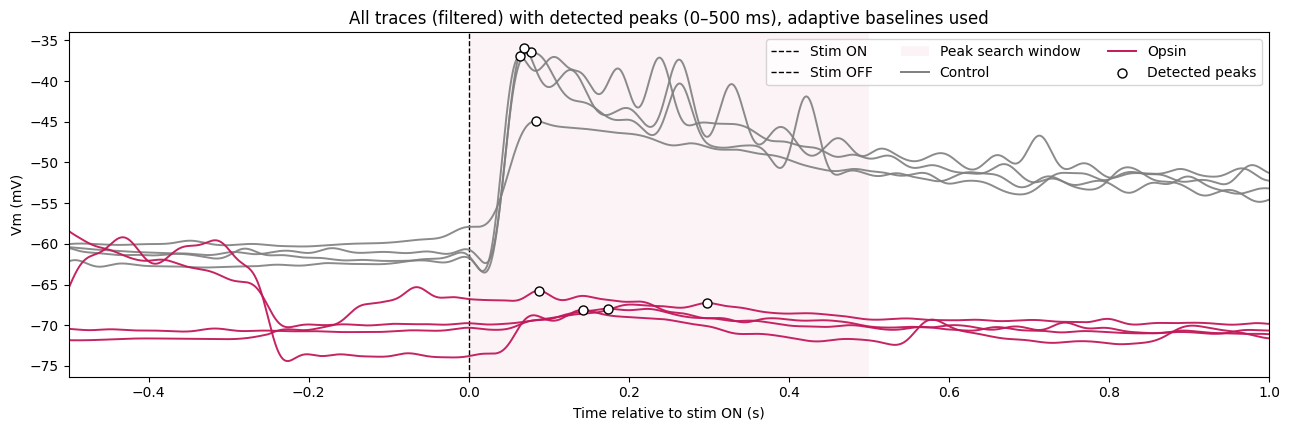

C:\Users\m.dhanasekar\AppData\Local\Temp\ipykernel_32756\1729506456.py:333: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=True)


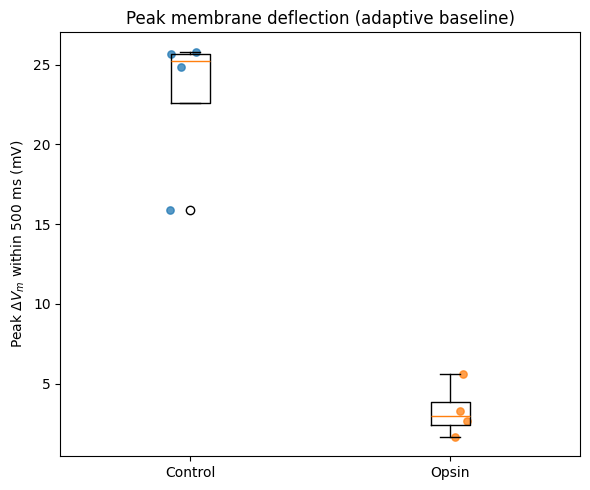

=== Peak Deflection (0–500 ms) with Adaptive Baseline ===
Output directory: C:\Maha\DATA\patch_clamp\Kevin\synaptic_connectivity
N_control = 4, mean = 23.041 mV, SD = 4.786
N_opsin   = 4,  mean = 3.296 mV, SD = 1.668
Normality p-values (Shapiro): Control=0.012490555449072769, Opsin=0.6569272579592176
Test used: Mann–Whitney U | Statistic = 16, p = 0.02857
Effect size: Rank-biserial r (Opsin vs Control) = -1
- Saved individual PDFs per trace (with baseline span + peak marker)
- Overlay SVG: C:\Maha\DATA\patch_clamp\Kevin\synaptic_connectivity\AllTraces_adaptivePeak_0to500ms.svg
- Boxplots: C:\Maha\DATA\patch_clamp\Kevin\synaptic_connectivity\PeakDeflection_adaptive_0to500ms_Boxplot.pdf | C:\Maha\DATA\patch_clamp\Kevin\synaptic_connectivity\PeakDeflection_adaptive_0to500ms_Boxplot.svg
- Stats TXT: C:\Maha\DATA\patch_clamp\Kevin\synaptic_connectivity\PeakDeflection_adaptive_0to500ms_stats.txt
- Summary CSV: C:\Maha\DATA\patch_clamp\Kevin\synaptic_connectivity\PeakDeflection_adaptive_0to50

In [19]:
# JUPYTER CELL — Adaptive Baseline + Peak Detection (0–500 ms), Plots w/ Peak Markers, Stats & Saves
# - Concatenate 3 ABFs per folder (pre, stim, post) in numeric order
# - Low-pass filter Vm (Butterworth)
# - ADAPTIVE BASELINE: auto-shift to a flatter 200 ms window up to 2 s before onset if the default is sloped
# - Peak search: 0–500 ms post-onset; choose larger-magnitude deflection (max or min) vs baseline
# - Save individual PDFs (with baseline window shaded + peak marker), overlay SVG (all traces + peaks), boxplot PDFs/SVGs
# - Print and save stats (UTF-8)

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyabf
from scipy.signal import butter, filtfilt
from scipy.stats import shapiro, ttest_ind, mannwhitneyu

# ---------------- USER CONFIG ----------------
CONTROL_FOLDERS = [
    r"C:\Maha\DATA\patch_clamp\Kevin\synaptic_connectivity\control\100624_F1_C1\CC\t1",
    r"C:\Maha\DATA\patch_clamp\Kevin\synaptic_connectivity\control\100624_F1_C1\CC\t2",
    r"C:\Maha\DATA\patch_clamp\Kevin\synaptic_connectivity\control\100624_F1_C1\CC\t3",
    r"C:\Maha\DATA\patch_clamp\Kevin\synaptic_connectivity\control\100624_F2_C1\CC\t1"
]
OPSIN_FOLDERS = [
   r"C:\Maha\DATA\patch_clamp\Kevin\synaptic_connectivity\opsin\140524_F1_C1\CC\t1",
   r"C:\Maha\DATA\patch_clamp\Kevin\synaptic_connectivity\opsin\140524_F1_C1\CC\t3",
   r"C:\Maha\DATA\patch_clamp\Kevin\synaptic_connectivity\opsin\140524_F1_C1\CC\t4",
   r"C:\Maha\DATA\patch_clamp\Kevin\synaptic_connectivity\opsin\150424_F1_C1\CC\t1",
]

VM_CHANNEL = 0

# Stimulus timing (absolute, on the concatenated timeline)
STIM_START_ABS  = 100.25   # s
STIM_DURATION_S = 3.0      # s
PEAK_WINDOW_S   = 0.500    # search window after onset

# Baseline search parameters
BASELINE_WIN_S  = 0.200    # desired baseline window length
BASELINE_LOOKBACK_S = 2.0  # search up to 2 s before onset
BASELINE_STEP_S = 0.010    # slide step (10 ms)
SLOPE_THR_MV_PER_S = 2.0   # "flat" if |dV/dt| <= 2 mV/s (adjust)
STD_THR_MV         = 1.0   # and std <= 1 mV (adjust)

# Filter
LP_CUTOFF_HZ = 20.0
LP_ORDER     = 4

# Plotting
COLOR_CONTROL = "#7f7f7f"   # grey
COLOR_OPSIN   = "#C2185B"   # dark pink
PEAK_MARKER_EDGE = "#000000"
PEAK_MARKER_SIZE = 42
LW_TRACE      = 1.4
ALPHA_CTRL    = 0.9
ALPHA_OPS     = 0.95
# zoom bounds relative to stim ON (focus on early responses)
ZOOM_PAD_PRE  = 0.50
ZOOM_PAD_POST = 0.50

# ---------------- HELPERS ----------------
def numeric_key(path):
    fname = os.path.basename(path)
    nums = re.findall(r"\d+", fname)
    return tuple(int(n) for n in nums) if nums else (fname.lower(),)

def list_three_abfs_sorted(folder):
    abfs = [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(".abf")]
    if len(abfs) != 3:
        raise ValueError(f"{folder}: expected 3 ABFs, found {len(abfs)}")
    abfs.sort(key=numeric_key)
    return abfs

def concat_abfs(folder, vm_channel=0):
    abf_paths = list_three_abfs_sorted(folder)
    t_all, v_all, t_off = [], [], 0.0
    for p in abf_paths:
        abf = pyabf.ABF(p)
        for s in range(abf.sweepCount):
            abf.setSweep(s, channel=vm_channel)
            x, y = abf.sweepX.copy(), abf.sweepY.copy()
            t_all.append(x + t_off)
            v_all.append(y)
            t_off += x[-1]
    return np.concatenate(t_all), np.concatenate(v_all), abf_paths

def compute_fs(t):
    dt = float(np.median(np.diff(t)))
    if dt <= 0:
        raise ValueError("Non-increasing time vector.")
    return 1.0 / dt

def butter_lowpass_filter(data, cutoff, fs, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, cutoff/nyq, btype="low", analog=False)
    return filtfilt(b, a, data)

def window_mask(t, t0, t1):
    return (t >= t0) & (t <= t1)

def find_flat_baseline(t, v, stim_on_s,
                       win_s=0.200, lookback_s=2.0, step_s=0.010,
                       slope_thr=2.0, std_thr=1.0):
    """
    Slide a window up to `lookback_s` before stim_on.
    Prefer windows with |slope| <= slope_thr (mV/s) and std <= std_thr (mV).
    If none meet both, select min(score) = |slope|/slope_thr + std/std_thr.
    Returns (b0, b1, baseline_mean, info_dict).
    """
    t0_min = max(t[0], stim_on_s - lookback_s)
    t1_max = stim_on_s
    if t1_max - t0_min < win_s + step_s:
        # fallback to last win_s before stim
        b1 = min(stim_on_s, t[-1])
        b0 = max(t[0], b1 - win_s)
        m = window_mask(t, b0, b1)
        return b0, b1, float(np.mean(v[m])) if np.any(m) else np.nan, {
            "picked": "fallback_short", "b0": b0, "b1": b1, "slope": np.nan, "std": np.nan, "score": np.nan
        }

    ends = np.arange(stim_on_s, stim_on_s - lookback_s - 1e-9, -step_s)
    best = None
    good = []
    for te in ends:
        ts = te - win_s
        if ts < t0_min or te > t1_max:
            continue
        m = window_mask(t, ts, te)
        if np.count_nonzero(m) < 5:
            continue
        tt = t[m]
        vv = v[m]
        # slope via linear fit (mV/s)
        a, b = np.polyfit(tt, vv, 1)
        slope = float(a)
        std = float(np.std(vv, ddof=1)) if vv.size > 1 else 0.0
        score = abs(slope)/max(slope_thr, 1e-9) + std/max(std_thr, 1e-9)
        rec = (score, ts, te, slope, std, float(np.mean(vv)))
        if abs(slope) <= slope_thr and std <= std_thr:
            good.append(rec)
        if (best is None) or (score < best[0]):
            best = rec

    pick = min(good, key=lambda r: r[0]) if good else best
    score, ts, te, slope, std, meanv = pick
    return ts, te, meanv, {
        "picked": "good" if good else "best_score",
        "b0": ts, "b1": te, "slope": slope, "std": std, "score": score
    }

def pick_peak_auto(v, t, baseline, t0, t1):
    """Return (t_peak, v_peak). Picks larger-magnitude deflection (max or min) in [t0, t1] vs baseline."""
    m = window_mask(t, t0, t1)
    if not np.any(m):
        return np.nan, np.nan
    seg = v[m]; tse = t[m]
    vmax = np.max(seg); tmax = tse[np.argmax(seg)]
    vmin = np.min(seg); tmin = tse[np.argmin(seg)]
    if abs(vmax - baseline) >= abs(vmin - baseline):
        return float(tmax), float(vmax)
    else:
        return float(tmin), float(vmin)

# ---------------- ROOT OUTPUT ----------------
root_dir = os.path.commonpath(CONTROL_FOLDERS + OPSIN_FOLDERS)
os.makedirs(root_dir, exist_ok=True)

# ---------------- PROCESS ----------------
records = []        # rows for CSV/stats
overlay_ctrl = []   # (t_rel, v_rel, t_peak_rel, v_peak, b0_rel, b1_rel, color)
overlay_ops  = []

z0_rel = -ZOOM_PAD_PRE
z1_rel = PEAK_WINDOW_S + ZOOM_PAD_POST

for group, folders, color in [("Control", CONTROL_FOLDERS, COLOR_CONTROL),
                              ("Opsin",   OPSIN_FOLDERS,   COLOR_OPSIN)]:
    for i, folder in enumerate(folders, 1):
        t, v, abf_paths = concat_abfs(folder, VM_CHANNEL)
        fs = compute_fs(t)
        vf = butter_lowpass_filter(v, LP_CUTOFF_HZ, fs, LP_ORDER)

        # Adaptive baseline (search up to lookback before onset)
        b0, b1, baseline, binfo = find_flat_baseline(
            t, vf, STIM_START_ABS,
            win_s=BASELINE_WIN_S,
            lookback_s=BASELINE_LOOKBACK_S,
            step_s=BASELINE_STEP_S,
            slope_thr=SLOPE_THR_MV_PER_S,
            std_thr=STD_THR_MV
        )

        # Peak in 0–500 ms post ON
        resp0, resp1 = STIM_START_ABS, STIM_START_ABS + PEAK_WINDOW_S
        t_peak, v_peak = pick_peak_auto(vf, t, baseline, resp0, resp1)
        dVm = (v_peak - baseline) if (np.isfinite(v_peak) and np.isfinite(baseline)) else np.nan

        # ---------- Plot individual with baseline window & peak ----------
        t_rel = t - STIM_START_ABS
        m_zoom = window_mask(t_rel, z0_rel, z1_rel)

        plt.figure(figsize=(12, 3.8))
        plt.plot(t_rel[m_zoom], vf[m_zoom], color=color, lw=LW_TRACE,
                 alpha=ALPHA_OPS if group=="Opsin" else ALPHA_CTRL, label=f"{group} (filtered)")

        # Shade chosen baseline window (relative)
        b0_rel = b0 - STIM_START_ABS
        b1_rel = b1 - STIM_START_ABS
        plt.axvspan(b0_rel, b1_rel, alpha=0.12, color="k", linewidth=0, label="Baseline (adaptive)")

        # Shade peak search window (relative)
        plt.axvspan(0.0, PEAK_WINDOW_S, alpha=0.08, color=color, linewidth=0, label="Peak search")

        # Stim lines
        plt.axvline(0.0, linestyle="--", color="k", lw=1)
        plt.axvline(STIM_DURATION_S, linestyle="--", color="k", lw=1)

        # Peak marker (only if inside zoom)
        tpk_rel = t_peak - STIM_START_ABS if np.isfinite(t_peak) else np.nan
        if np.isfinite(tpk_rel) and (tpk_rel >= z0_rel) and (tpk_rel <= z1_rel):
            plt.scatter(tpk_rel, v_peak, s=PEAK_MARKER_SIZE,
                        facecolor="white", edgecolor=PEAK_MARKER_EDGE, zorder=5, label="Detected peak")

        tag = " + ".join(os.path.basename(p) for p in abf_paths)
        plt.title(f"{group} — Adaptive baseline & peak (0–500 ms)\n{tag}")
        plt.xlabel("Time relative to stim ON (s)")
        plt.ylabel("Vm (mV)")
        plt.xlim(z0_rel, z1_rel)
        plt.legend(loc="upper right")
        plt.tight_layout()

        out_pdf = os.path.join(root_dir, f"{group}_adaptivePeak_{i:02d}.pdf")
        plt.savefig(out_pdf, format="pdf")
        plt.close()

        # For overlay
        overlay_item = (t_rel[m_zoom], vf[m_zoom], tpk_rel, v_peak, b0_rel, b1_rel, color)
        if group == "Control":
            overlay_ctrl.append(overlay_item)
        else:
            overlay_ops.append(overlay_item)

        # Record row
        records.append({
            "group": group,
            "folder": folder,
            "fs_Hz": fs,
            "baseline_start_s": b0,
            "baseline_end_s": b1,
            "baseline_mean_mV": baseline,
            "peak_time_s": t_peak,
            "peak_value_mV": v_peak,
            "deflection_mV": dVm,
            "baseline_pick": binfo.get("picked"),
            "baseline_slope_mV_per_s": binfo.get("slope"),
            "baseline_std_mV": binfo.get("std"),
            "baseline_score": binfo.get("score"),
            "trace_pdf": out_pdf
        })

# ---------- Overlay with peaks (all traces) ----------
plt.figure(figsize=(13, 4.4))
plt.axvline(0.0, linestyle="--", color="k", lw=1, label="Stim ON")
plt.axvline(STIM_DURATION_S, linestyle="--", color="k", lw=1, label="Stim OFF")
plt.axvspan(0.0, PEAK_WINDOW_S, alpha=0.05, color=COLOR_OPSIN, linewidth=0, label="Peak search window")

# proxies for legend
plt.plot([], [], color=COLOR_CONTROL, lw=LW_TRACE, label="Control")
plt.plot([], [], color=COLOR_OPSIN,   lw=LW_TRACE, label="Opsin")
plt.scatter([], [], s=PEAK_MARKER_SIZE, facecolor="white", edgecolor=PEAK_MARKER_EDGE, label="Detected peaks")

for trel, vrel, tpk, vpk, b0r, b1r, col in overlay_ctrl:
    plt.plot(trel, vrel, color=COLOR_CONTROL, lw=LW_TRACE, alpha=ALPHA_CTRL)
    if np.isfinite(tpk) and (trel.min() <= tpk <= trel.max()):
        plt.scatter(tpk, vpk, s=PEAK_MARKER_SIZE, facecolor="white", edgecolor=PEAK_MARKER_EDGE, zorder=5)
for trel, vrel, tpk, vpk, b0r, b1r, col in overlay_ops:
    plt.plot(trel, vrel, color=COLOR_OPSIN, lw=LW_TRACE, alpha=ALPHA_OPS)
    if np.isfinite(tpk) and (trel.min() <= tpk <= trel.max()):
        plt.scatter(tpk, vpk, s=PEAK_MARKER_SIZE, facecolor="white", edgecolor=PEAK_MARKER_EDGE, zorder=5)

plt.title("All traces (filtered) with detected peaks (0–500 ms), adaptive baselines used")
plt.xlabel("Time relative to stim ON (s)")
plt.ylabel("Vm (mV)")
plt.xlim(-ZOOM_PAD_PRE, PEAK_WINDOW_S + ZOOM_PAD_POST)
plt.legend(loc="upper right", ncol=3)
plt.tight_layout()
overlay_svg = os.path.join(root_dir, "AllTraces_adaptivePeak_0to500ms.svg")
plt.savefig(overlay_svg, format="svg", dpi=300)
plt.show()

# ---------- Stats: ΔVm = peak - baseline ----------
df = pd.DataFrame(records)
ctrl = df.loc[df["group"]=="Control", "deflection_mV"].dropna().to_numpy()
ops  = df.loc[df["group"]=="Opsin",   "deflection_mV"].dropna().to_numpy()

# Normality checks (if n>=3)
def safe_shapiro(x):
    try:
        return shapiro(x).pvalue if len(x) >= 3 else np.nan
    except Exception:
        return np.nan

p_ctrl_norm = safe_shapiro(ctrl)
p_ops_norm  = safe_shapiro(ops)
use_param = (np.all(np.array([p_ctrl_norm, p_ops_norm]) > 0.05) and len(ctrl) >= 2 and len(ops) >= 2)

if use_param:
    test_name = "Welch's t-test"
    stat, pval = ttest_ind(ctrl, ops, equal_var=False, nan_policy="omit")
    # Hedges' g (Opsin − Control)
    def hedges_g(a, b):
        na, nb = len(a), len(b)
        sa, sb = np.var(a, ddof=1), np.var(b, ddof=1)
        sp = np.sqrt(((na-1)*sa + (nb-1)*sb) / (na + nb - 2)) if (na+nb-2) > 0 else np.nan
        if not np.isfinite(sp) or sp == 0:
            return np.nan
        d = (np.mean(b) - np.mean(a)) / sp
        J = 1 - (3 / (4*(na + nb) - 9))
        return J * d
    effect_name = "Hedges' g (Opsin−Control)"
    effect = hedges_g(ctrl, ops)
else:
    test_name = "Mann–Whitney U"
    stat, pval = mannwhitneyu(ctrl, ops, alternative="two-sided")
    n1, n2 = len(ctrl), len(ops)
    effect_name = "Rank-biserial r (Opsin vs Control)"
    effect = (1 - (2 * stat) / (n1 * n2)) if (n1 > 0 and n2 > 0) else np.nan

# Boxplot (ΔVm) + jittered points
plt.figure(figsize=(6,5))
data = [ctrl, ops]
labels = ["Control", "Opsin"]
plt.boxplot(data, labels=labels, showfliers=True)
rng = np.random.default_rng(0)
for i, vals in enumerate(data, start=1):
    if len(vals):
        x = np.full_like(vals, i, dtype=float) + rng.uniform(-0.08, 0.08, size=len(vals))
        plt.scatter(x, vals, s=28, alpha=0.75)
plt.ylabel(r'Peak $\Delta V_m$ within 500 ms (mV)')
plt.title("Peak membrane deflection (adaptive baseline)")
plt.tight_layout()
box_pdf = os.path.join(root_dir, "PeakDeflection_adaptive_0to500ms_Boxplot.pdf")
box_svg = os.path.join(root_dir, "PeakDeflection_adaptive_0to500ms_Boxplot.svg")
plt.savefig(box_pdf, format="pdf"); plt.savefig(box_svg, format="svg", dpi=300)
plt.show()

# ---------- Save & Print ----------
summary_csv = os.path.join(root_dir, "PeakDeflection_adaptive_0to500ms_summary.csv")
stats_txt   = os.path.join(root_dir, "PeakDeflection_adaptive_0to500ms_stats.txt")
df.to_csv(summary_csv, index=False)

with open(stats_txt, "w", encoding="utf-8") as f:
    f.write("Peak ΔV_m = (Vm_peak − Vm_baseline) within 0–0.5 s after onset (adaptive baseline)\n")
    f.write(f"Baseline window target: {BASELINE_WIN_S:.3f}s; search up to {BASELINE_LOOKBACK_S:.3f}s before onset\n")
    f.write(f"Flatness thresholds: |slope| ≤ {SLOPE_THR_MV_PER_S:.3f} mV/s and std ≤ {STD_THR_MV:.3f} mV\n")
    f.write(f"Filter: Butterworth low-pass, order={LP_ORDER}, cutoff={LP_CUTOFF_HZ} Hz\n\n")
    f.write(f"N_control = {len(ctrl)}, mean = {np.nanmean(ctrl):.3f} mV, SD = {np.nanstd(ctrl, ddof=1):.3f}\n")
    f.write(f"N_opsin   = {len(ops)},  mean = {np.nanmean(ops):.3f} mV, SD = {np.nanstd(ops, ddof=1):.3f}\n\n")
    f.write(f"Normality p-values (Shapiro): Control={p_ctrl_norm}, Opsin={p_ops_norm}\n")
    f.write(f"Test used: {test_name}\n")
    f.write(f"Statistic = {stat:.4g}, p = {pval:.4g}\n")
    f.write(f"Effect size: {effect_name} = {effect:.4g}\n")
    f.write(f"Overlay SVG: {overlay_svg}\n")
    f.write(f"Boxplot PDF/SVG: {box_pdf} | {box_svg}\n")
    f.write(f"Summary CSV: {summary_csv}\n")

print("=== Peak Deflection (0–500 ms) with Adaptive Baseline ===")
print(f"Output directory: {root_dir}")
print(f"N_control = {len(ctrl)}, mean = {np.nanmean(ctrl):.3f} mV, SD = {np.nanstd(ctrl, ddof=1):.3f}")
print(f"N_opsin   = {len(ops)},  mean = {np.nanmean(ops):.3f} mV, SD = {np.nanstd(ops, ddof=1):.3f}")
print(f"Normality p-values (Shapiro): Control={p_ctrl_norm}, Opsin={p_ops_norm}")
print(f"Test used: {test_name} | Statistic = {stat:.4g}, p = {pval:.4g}")
print(f"Effect size: {effect_name} = {effect:.4g}")
print(f"- Saved individual PDFs per trace (with baseline span + peak marker)")
print(f"- Overlay SVG: {overlay_svg}")
print(f"- Boxplots: {box_pdf} | {box_svg}")
print(f"- Stats TXT: {stats_txt}")
print(f"- Summary CSV: {summary_csv}")
